In [85]:
import os
import json
import requests

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

In [83]:
WIKIDATA_QUERY = """
SELECT DISTINCT ?item ?itemLabel WHERE {
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
  {
    SELECT DISTINCT ?item WHERE {
      ?item p:P646 ?statement0.
      ?statement0 (ps:P646) "%s".
    }
    LIMIT 100
  }
}

"""

In [2]:
MOVIES_COLUMNS = [
    "Wikipedia movie ID",
    "Freebase movie ID",
    "Movie name",
    "Movie release date",
    "Movie box office revenue",
    "Movie runtime",
    "Movie languages",
    "Movie countries",
    "Movie genres"
]
ACTORS_COLUMNS = [
    "Wikipedia movie ID",
    "Freebase movie ID",
    "Movie release date",
    "Character name",
    "Actor date of birth",
    "Actor gender",
    "Actor height",
    "Actor ethnicity",
    "Actor name",
    "Actor age at movie release",
    "Freebase character/actor map ID",
    "Freebase character ID",
    "Freebase actor ID"
]
MOVIES_PATH = os.path.abspath(os.path.join("MovieSummaries",
                                           "movie.metadata.tsv"))
ACTORS_PATH = os.path.abspath(os.path.join("MovieSummaries",
                                           "character.metadata.tsv"))

In [3]:
movies = pd.read_csv(MOVIES_PATH, delimiter="\t", header=None)
movies.columns = MOVIES_COLUMNS
movies

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


In [4]:
movies["Movie release date"] = pd.to_datetime(movies["Movie release date"], errors="coerce")
movies

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}"
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


In [5]:
movies.describe()

,Wikipedia movie ID,Movie box office revenue,Movie runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


In [6]:
np.sum(movies["Movie runtime"] > 500)

46

In [7]:
movies.loc[movies["Movie runtime"] > 1000, "Movie runtime"] = np.nan
movies.loc[movies["Movie runtime"] == 0.0, "Movie runtime"] = np.nan

In [8]:
def get_main_val(row, col):
    info = json.loads(row[col])
    if info:
        return list(info.values())[0]
    return np.nan

In [9]:
def get_count_val(row, col):
    info = json.loads(row[col])
    return len(info)

In [10]:
def get_main_genre(row):
    return get_main_val(row, "Movie genres")

In [11]:
def get_count_countries(row):
    return get_count_val(row, "Movie countries")

In [12]:
movies["Main genre"] = movies.apply(get_main_genre, axis=1)
movies["Countries count"] = movies.apply(get_count_countries, axis=1)

In [13]:
100*np.mean(pd.isna(movies), axis=0)

Wikipedia movie ID           0.000000
Freebase movie ID            0.000000
Movie name                   0.000000
Movie release date           8.444966
Movie box office revenue    89.722416
Movie runtime               25.041289
Movie languages              0.000000
Movie countries              0.000000
Movie genres                 0.000000
Main genre                   2.806425
Countries count              0.000000
dtype: float64

In [14]:
movies.describe()

,Wikipedia movie ID,Movie box office revenue,Movie runtime,Countries count
count,8.174100e+04,8.401000e+03,61272.000000,81741.000000
mean,1.740784e+07,4.799363e+07,93.214050,1.057474
std,1.098791e+07,1.121753e+08,37.172618,0.623572
min,3.300000e+02,1.000000e+04,0.030000,0.000000
25%,7.323695e+06,2.083193e+06,81.000000,1.000000
50%,1.777899e+07,1.063969e+07,93.000000,1.000000
75%,2.715573e+07,4.071696e+07,106.000000,1.000000
max,3.750192e+07,2.782275e+09,900.000000,14.000000


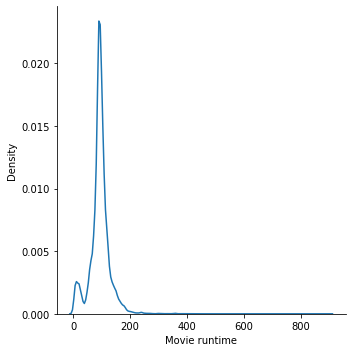

In [15]:
sns.displot(data=movies, x="Movie runtime", kind="kde")
plt.show()

In [16]:
genre_count = movies.groupby("Main genre").count().iloc[:, 0].sort_values(ascending=False)
genre_count

Main genre
Drama                       11516
Short Film                   7598
Thriller                     7168
Crime Fiction                5202
Romance Film                 3410
                            ...  
Master Criminal Films           1
Social issues                   1
Space opera                     1
Libraries and librarians        1
Costume Horror                  1
Name: Wikipedia movie ID, Length: 293, dtype: int64

In [17]:
genre_count.index

Index(['Drama', 'Short Film', 'Thriller', 'Crime Fiction', 'Romance Film',
       'Silent film', 'Comedy', 'Comedy film', 'Romantic comedy',
       'Documentary',
       ...
       'Mumblecore', 'Buddy Picture', 'Monster', 'Doomsday film', 'Dystopia',
       'Master Criminal Films', 'Social issues', 'Space opera',
       'Libraries and librarians', 'Costume Horror'],
      dtype='object', name='Main genre', length=293)

In [18]:
top_genres = genre_count.index[:5]
top_genres

Index(['Drama', 'Short Film', 'Thriller', 'Crime Fiction', 'Romance Film'], dtype='object', name='Main genre')

In [19]:
movies_top_genres = movies[movies["Main genre"].isin(top_genres)]
movies_top_genres

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Main genre,Countries count
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Thriller,1
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",Crime Fiction,1
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",Thriller,1
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",Drama,1
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",Short Film,1
...,...,...,...,...,...,...,...,...,...,...,...
81731,23687925,/m/06zmdnc,La Ragazza di Trieste,1952-01-01,NaN,NaN,"{""/m/02bjrlw"": ""Italian Language""}","{""/m/03rjj"": ""Italy""}","{""/m/02l7c8"": ""Romance Film"", ""/m/07s9rl0"": ""D...",Romance Film,1
81733,23851782,/m/06_vb43,The Ghost Train,1941-05-03,NaN,82.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",Crime Fiction,1
81734,12095128,/m/02vppbd,My Love,NaT,NaN,26.0,"{""/m/06b_j"": ""Russian Language""}","{""/m/06bnz"": ""Russia""}","{""/m/02hmvc"": ""Short Film""}",Short Film,1
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",Drama,1


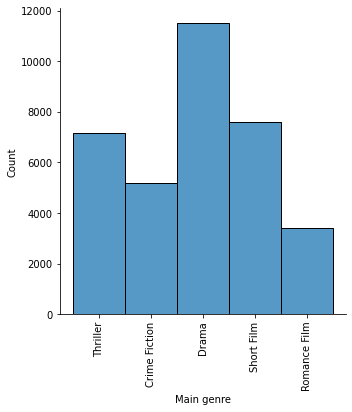

In [20]:
sns.displot(data=movies_top_genres, x="Main genre")
plt.xticks(rotation=90)
plt.show()

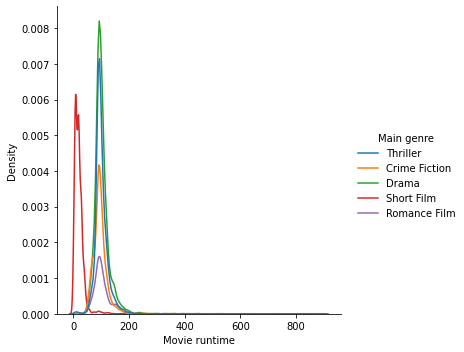

In [21]:
sns.displot(data=movies_top_genres, x="Movie runtime", kind="kde",
            hue="Main genre")
plt.show()

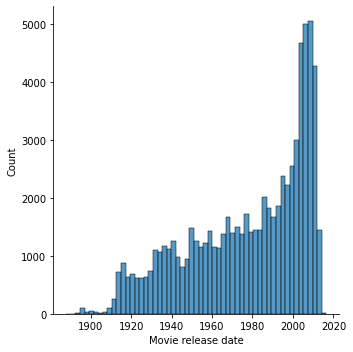

In [22]:
sns.displot(data=movies, x="Movie release date")
plt.show()

/home/alehc/.local/lib/python3.10/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


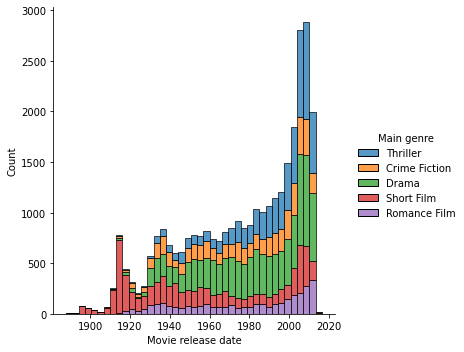

In [23]:
sns.displot(data=movies_top_genres, x="Movie release date",
            hue="Main genre", multiple="stack")
plt.show()

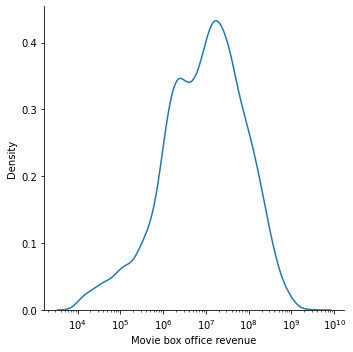

In [24]:
sns.displot(data=movies, x="Movie box office revenue", kind="kde",
            log_scale=True)
plt.show()

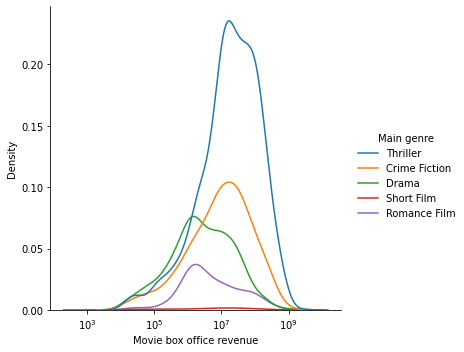

In [25]:
sns.displot(data=movies_top_genres, x="Movie box office revenue", kind="kde",
            hue="Main genre", log_scale=True)
plt.show()

In [26]:
movies["Freebase movie ID"]

0         /m/03vyhn
1         /m/08yl5d
2        /m/0crgdbh
3        /m/0285_cd
4         /m/01mrr1
            ...    
81736    /m/0j7hxnt
81737    /m/0g4pl34
81738    /m/02pygw1
81739     /m/03pcrp
81740    /m/02w7zz8
Name: Freebase movie ID, Length: 81741, dtype: object

In [59]:
wikidata_client = Client()

# wikidata_imdb_property_id = "P345"
wikidata_imdb_property_id = "P444"
wikidata_imdb_property = wikidata_client.get(wikidata_imdb_property_id)

In [100]:
def get_rating(freebase_id):
    # freebase -> wikidata
    query = WIKIDATA_QUERY % freebase_id
    req = requests.get("https://query.wikidata.org/sparql",
                       params={"format": "json", "query": query})
    try:
        data = req.json()
        wikidata_id = data["results"]["bindings"][0]["itemLabel"]["value"]
    except:
        return np.nan
    
    # wikidata -> rotten tomatoes
    req = requests.get(f"https://www.wikidata.org/wiki/Special:EntityData/{wikidata_id}.json")
    try:
        data = req.json()
        reviews = data["entities"][wikidata_id]["claims"]["P444"]
        return len(reviews)
        # return reviews[0]["mainsnak"]["datavalue"]["value"]
        # for review in reviews:
            # method = review["qualifiers"]["P459"][0]["datavalue"]["value"]["id"]
            # if method == "Q108403393":  # tomatometer score
            # return int(review["mainsnak"]["datavalue"]["value"][:-1])  # format is xyz%
    except:
        return np.nan
    return np.nan
    # rating = entity[wikidata_imdb_property]
    # return int(rating[:-1])
    
    # # imdb -> rating
    # req = requests.get(f"https://imdb-api.com/en/API/Ratings/{IMDB_APIKEY}/tt1375666")
    # try:
    #     data = req.json()
    #     return float(data["imDb"])
    # except:
    #     return np.nan

In [101]:
x = np.array(list(map(get_rating, tqdm(movies["Freebase movie ID"][:100]))))
x

  0%|          | 0/100 [00:00<?, ?it/s]

array([ 2., nan, nan,  2., nan, nan, nan,  2., nan,  2., nan, nan, nan,
        2., nan, nan, nan,  2., nan, nan, nan,  2.,  2., nan, nan, nan,
       nan, nan, nan,  2., nan, nan, nan,  2., nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  2., nan, nan,
       nan,  2., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        2., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  2.,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [103]:
np.mean(np.isnan(x))

0.86

In [63]:
actors = pd.read_csv(ACTORS_PATH, delimiter="\t", header=None)
actors.columns = ACTORS_COLUMNS
actors

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


In [64]:
actors["Actor date of birth"] = pd.to_datetime(actors["Actor date of birth"], errors="coerce")
actors

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26 00:00:00,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15 00:00:00,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15 00:00:00,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12 00:00:00,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25 00:00:00,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05-01 00:00:00,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12 00:00:00,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18 00:00:00,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


In [65]:
100*np.mean(pd.isna(actors), axis=0)

Wikipedia movie ID                  0.000000
Freebase movie ID                   0.000000
Movie release date                  2.217814
Character name                     57.220488
Actor date of birth                23.557866
Actor gender                       10.120288
Actor height                       65.645740
Actor ethnicity                    76.466542
Actor name                          0.272484
Actor age at movie release         35.084064
Freebase character/actor map ID     0.000000
Freebase character ID              57.218269
Freebase actor ID                   0.180842
dtype: float64

In [67]:
100*np.mean(pd.isna(actors.drop_duplicates(["Actor name"])), axis=0)

Wikipedia movie ID                  0.000000
Freebase movie ID                   0.000000
Movie release date                  1.053110
Character name                     58.701213
Actor date of birth                56.765787
Actor gender                       28.192334
Actor height                       90.464577
Actor ethnicity                    93.955056
Actor name                          0.000746
Actor age at movie release         63.147846
Freebase character/actor map ID     0.000000
Freebase character ID              58.698230
Freebase actor ID                   0.000746
dtype: float64

In [77]:
# sns.displot(data=actors.groupby("Wikipedia movie ID").agg("count"), x="Freebase movie ID")
# plt.show()
actors.groupby("Wikipedia movie ID").agg("count").describe()

,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height,Actor ethnicity,Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
count,64330.000000,64330.000000,64330.000000,64330.000000,64330.000000,64330.000000,64330.000000,64330.000000,64330.000000,64330.000000,64330.000000,64330.000000
mean,7.005581,6.850210,2.996953,5.355215,6.296596,2.406715,1.648655,6.986492,4.547738,7.005581,2.997109,6.992912
std,5.420388,5.553736,5.226329,4.361247,5.130786,3.145754,2.299265,5.405299,4.431761,5.420388,5.226421,5.404312
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,3.000000,2.000000,0.000000,2.000000,2.000000,0.000000,0.000000,3.000000,1.000000,3.000000,0.000000,3.000000
50%,6.000000,6.000000,1.000000,4.000000,5.000000,1.000000,1.000000,6.000000,3.000000,6.000000,1.000000,6.000000
75%,10.000000,10.000000,3.000000,8.000000,9.000000,3.000000,2.000000,10.000000,7.000000,10.000000,3.000000,10.000000
max,115.000000,115.000000,115.000000,78.000000,115.000000,62.000000,32.000000,115.000000,78.000000,115.000000,115.000000,115.000000


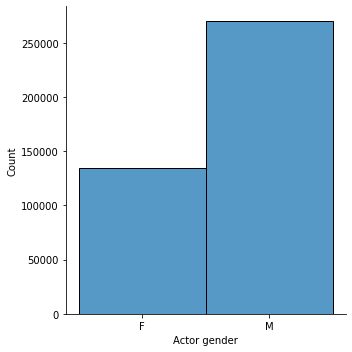

In [31]:
sns.displot(data=actors, x="Actor gender")
plt.show()

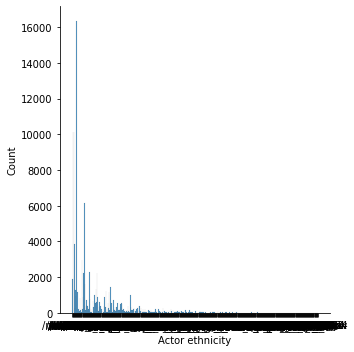

In [32]:
sns.displot(data=actors, x="Actor ethnicity")
plt.show()

In [33]:
sns.displot(data=actors, x="Actor date of birth")
plt.show()


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x7fc42876a710> (for post_execute):



KeyboardInterrupt



Error in callback <function flush_figures at 0x7fc4101ddea0> (for post_execute):



KeyboardInterrupt



In [ ]:
actor_count = actors.groupby("Actor name").count().iloc[:, 0].sort_values(ascending=False)
actor_count

In [ ]:
top_actors = actor_count.index[:10]
top_actors